In [2]:
def find_segment(func,low,high,precision):
    mid = (high-low)/2
    print(mid)
    if func(mid):
        return mid
    elif high-low<precision:
        return None
    else:
        high_mid = find_segment(func,mid,high,precision)
        if high is not None:
            return high_mid
        else:
            low_mid = find_segment(func,mid,high,precision)
            if high is not None:
                return low_mid
            else:
                return None
        
def example_function(x):
    # Define your function here
    return 0.03 <= x <= 0.04
find_segment(example_function,0,1,1e-2)

: 

In [42]:
import numpy as np
import time

def find_segment(func,low,high,precision):
    check_num = 3
    start = low
    end = high
    found = 0
    while True:
        checks = np.linspace(start,end,check_num)

        for i in range(1,len(checks)-2):
            if func(checks[i]):
                start = checks[i-1]
                found = 1

                break

        if checks[1]-checks[0]<precision:
            if found:
                break
            else:
                return -1

        check_num *= 2
    
    check_num = 3
    found = 0
    while True:
        checks = np.linspace(start,end,check_num)
        for i in range(len(checks) - 2, 0, -1):
            if func(checks[i]):
                end = checks[i+1]
                print(end)
                found = 1
                break

        if checks[1]-checks[0]<precision:
            if found:
                return start,end
            else:
                return -1

        check_num *= 2


start = time.time()
def example_function(x):
    # Define your function here
    return 0.0907 <= x <= 0.099
print(find_segment(example_function,0,1,1e-6))
stop = time.time()
print(f'{(stop-start):.5f}')

0.1002211977761553
0.09900304641447522
0.09900304641447522
0.09900304641447522
0.09900034263152344
0.09900034263152344
0.09900034263152344
(0.09069972896955378, 0.09900034263152344)
0.02478


In [22]:
def calculate_area_of_polygon(points):
    # Check if there are at least 3 points
    if len(points) < 3:
        return "Error: At least 3 points are needed to form a polygon."

    # Append the first point to the end to close the polygon
    points.append(points[0])

    # Initialize area variable
    area = 0

    # Calculate area using Shoelace formula
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        area += (x1 * y2 - x2 * y1)

    # Take absolute value of area and divide by 2
    area = abs(area) / 2

    return area

# Example usage:
points = [(-1, -1), (5, 0), (4, 3), (2, 5), (0, 3)]
print("Area of the polygon:", calculate_area_of_polygon(points))
from shapely.geometry import Polygon
print("Area of the polygon:", Polygon(points).area)

Area of the polygon: 21.5
Area of the polygon: 21.5


Smooth intersection area: 0.002209403784945607


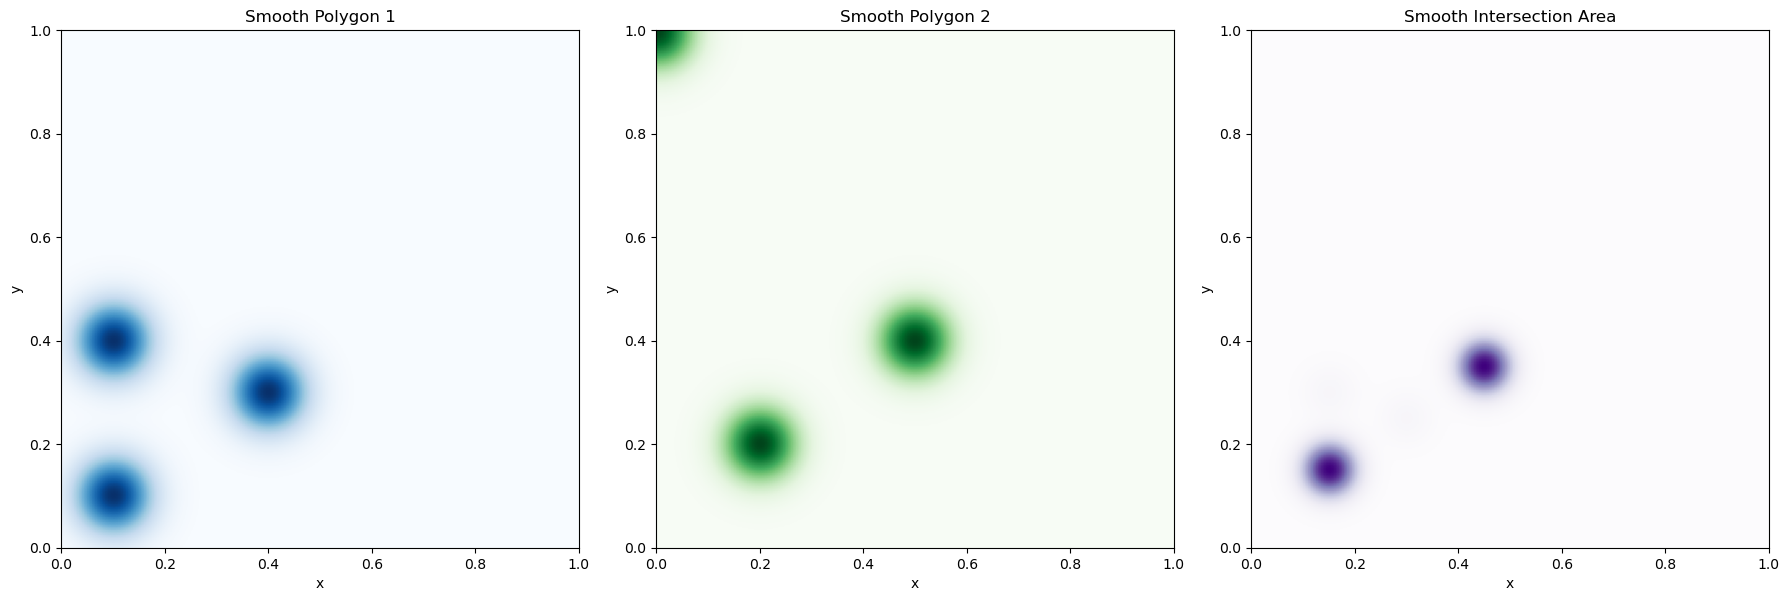

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Gaussian function
def gaussian(x, y, cx, cy, sigma):
    return torch.exp(-((x - cx) ** 2 + (y - cy) ** 2) / (2 * sigma ** 2))

# Function to create a smooth approximation of a polygon
def smooth_polygon(points, grid_size=100, sigma=0.1, device="cpu"):
    """
    Create a smooth approximation of a polygon using Gaussian bumps.
    
    Arguments:
    - points: (N, 2) tensor of points defining the polygon.
    - grid_size: Size of the grid to evaluate the Gaussians on.
    - sigma: Spread of the Gaussians.
    
    Returns:
    - A grid representing the smooth approximation of the polygon.
    """
    x = torch.linspace(0, 1, grid_size, device=device)
    y = torch.linspace(0, 1, grid_size, device=device)
    X, Y = torch.meshgrid(x, y, indexing='ij')

    polygon_approx = torch.zeros((grid_size, grid_size), device=device)
    
    # Add a Gaussian bump for each point in the polygon
    for cx, cy in points:
        polygon_approx += gaussian(X, Y, cx, cy, sigma)
    
    # Normalize the result to avoid values larger than 1
    polygon_approx = torch.clamp(polygon_approx, 0, 1)
    
    return polygon_approx

# Function to calculate the smooth intersection area
def smooth_intersection_area(points1, points2, grid_size=100, sigma=0.1, device="cpu"):
    """
    Calculate the smooth intersection area between two polygons.
    
    Arguments:
    - points1: (N1, 2) tensor of points for the first polygon.
    - points2: (N2, 2) tensor of points for the second polygon.
    - grid_size: Size of the grid to evaluate the Gaussians on.
    - sigma: Spread of the Gaussians.
    
    Returns:
    - Approximate intersection area between the two polygons.
    """
    poly1_approx = smooth_polygon(points1, grid_size, sigma, device)
    poly2_approx = smooth_polygon(points2, grid_size, sigma, device)
    
    # The overlap is the product of the two smooth approximations
    overlap = poly1_approx * poly2_approx
    
    # Approximate the intersection area by summing over the grid
    intersection_area = torch.sum(overlap) / (grid_size ** 2)
    
    return intersection_area, poly1_approx, poly2_approx, overlap

# Function to plot all smooth polygons in one figure
def plot_all_smooth_polygons(poly1_approx, poly2_approx, overlap, grid_size=100):
    """
    Plot the smooth polygons and their intersection in a single figure with subplots.
    
    Arguments:
    - poly1_approx: Smooth approximation of the first polygon.
    - poly2_approx: Smooth approximation of the second polygon.
    - overlap: Overlap between the two polygons.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(poly1_approx.cpu().numpy(), extent=[0, 1, 0, 1], origin='lower', cmap='Blues')
    axs[0].set_title("Smooth Polygon 1")
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    
    axs[1].imshow(poly2_approx.cpu().numpy(), extent=[0, 1, 0, 1], origin='lower', cmap='Greens')
    axs[1].set_title("Smooth Polygon 2")
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    
    axs[2].imshow(overlap.cpu().numpy(), extent=[0, 1, 0, 1], origin='lower', cmap='Purples')
    axs[2].set_title("Smooth Intersection Area")
    axs[2].set_xlabel('x')
    axs[2].set_ylabel('y')

    plt.tight_layout()
    plt.show()

# Example usage
device = torch.device("cpu")  # Set to "cuda" if you want to use a GPU

# Define two sets of points representing polygons (as tensors)
points1 = torch.tensor([[0.1, 0.1], [0.4, 0.1], [0.3, 0.4]], device=device)
points2 = torch.tensor([[0.2, 0.2], [1, 0], [0.4, 0.5]], device=device)

# Calculate the smooth intersection area and get the smooth polygons
intersection_area, poly1_approx, poly2_approx, overlap = smooth_intersection_area(
    points1, points2, grid_size=200, sigma=0.05, device=device)

# Print the smooth intersection area
print("Smooth intersection area:", intersection_area.item())

# Plot all smooth polygons in one figure
plot_all_smooth_polygons(poly1_approx, poly2_approx, overlap)


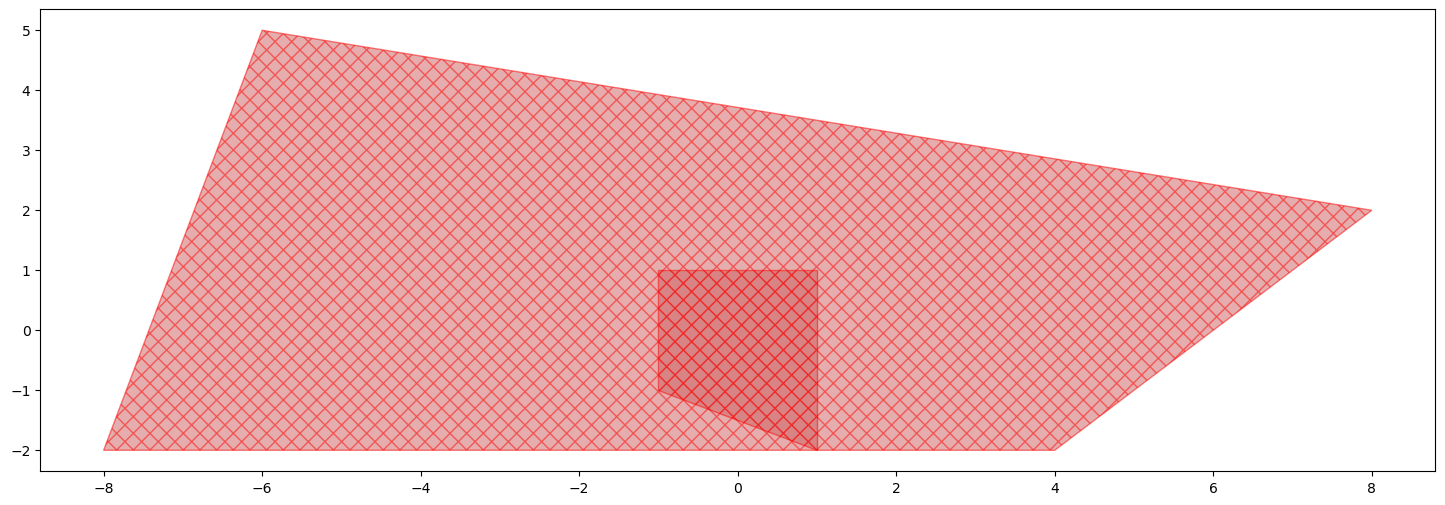

In [3]:
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 6))
polygons = [Polygon([(-8, -2), (-6, 5), (8, 2), (4, -2)]),Polygon([(-1, -1), (-1, 1), (1, 1), (1, -2)])]
for poly in polygons:
    x, y = poly.exterior.xy
    ax.fill(x, y, hatch='xx', color='indianred', edgecolor='red',alpha = 0.5)

In [5]:
import numpy as np
np.linalg.norm(((-10,10),(-10,10)))

20.0